In [51]:
MODELS_FROM_FILE = 1
IMPORTANCES_FROM_FILE = 1

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.linear_model import ElasticNet

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

from sklearn.pipeline import make_pipeline

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, recall_score, precision_score, balanced_accuracy_score, f1_score, roc_auc_score, fbeta_score, make_scorer, roc_curve, precision_recall_curve, accuracy_score, r2_score, mean_absolute_error
from sklearn.metrics import PrecisionRecallDisplay, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

    
pd.set_option("display.max_columns", None)
pd.set_option('max_colwidth', None)


data_intermediate_dir = "data/intermediate/"
item_lvl_wo_imp = pd.read_csv(data_intermediate_dir + "item_lvl_wo_impairment.csv")

# Prepare input and ouptut column names

output_cols = [x for x in item_lvl_wo_imp.columns if x.startswith("WHODAS") or x.startswith("CIS")] # All impairment columns

input_cols = [x for x in item_lvl_wo_imp.columns if 
                       not x.startswith("Diag: ") 
                       and not x.startswith("WIAT")
                       and not x.startswith("WISC")
                       and not x.startswith("WHODAS")
                       and not x.startswith("CIS")] # Input columns are all columns except Diagnosis, WIAT, and WISC, impairment columns

# Separate test set for all impairment scores

# Shuffle the dataset 
shuffle_df = item_lvl_wo_imp.sample(frac=1, random_state=42)

# Define a size for the train set 
train_size = int(0.7 * len(item_lvl_wo_imp))

# Split the dataset 
train_set = shuffle_df[:train_size]
test_set = shuffle_df[train_size:] # Don't touch this until the end

# Train_train and Validation set
# Define a size for your train_train set 
train_train_size = int(0.7 * len(train_set))

# Split your dataset 
train_train_set = train_set[:train_train_size]
val_set = train_set[train_train_size:]

In [52]:
def get_base_models_and_param_grids():
    
    # Define base models
    dt = DecisionTreeRegressor()
    rf = RandomForestRegressor()
    svr = svm.SVR()
    en = ElasticNet()
    
    # Impute missing values
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    
    # Standardize data
    scaler = StandardScaler()

    # Make pipelines
    dt_pipe = make_pipeline(imputer, scaler, dt)
    rf_pipe = make_pipeline(imputer, scaler, rf)
    svr_pipe = make_pipeline(imputer, scaler, svr)
    en_pipe = make_pipeline(imputer, scaler, en)
    
    # Define parameter grids to search for each pipe
    from scipy.stats import loguniform, uniform
    dt_param_grid = {
        "decisiontreeregressor__splitter": ["best","random"],
        "decisiontreeregressor__min_samples_split": np.random.randint(2, 20, 30),
        "decisiontreeregressor__max_depth": np.random.randint(1, 30, 30),
        "decisiontreeregressor__min_samples_leaf": np.random.randint(1, 20, 30),
        "decisiontreeregressor__max_leaf_nodes": np.random.randint(2, 50, 30)
    }
    rf_param_grid = {
        'randomforestregressor__max_depth' : np.random.randint(5, 150, 30),
        'randomforestregressor__min_samples_split': np.random.randint(2, 50, 30),
        'randomforestregressor__n_estimators': np.random.randint(50, 400, 10),
        'randomforestregressor__min_samples_leaf': np.random.randint(1, 20, 30),
        'randomforestregressor__max_features': ['auto', 'sqrt', 'log2', 0.25, 0.5, 0.75, 1.0]
    }
    svr_param_grid = {
        'svr__C': loguniform(1e-03, 1e+02),
        'svr__gamma': loguniform(1e-03, 1e+02),
        'svr__degree': uniform(2, 5),
        'svr__epsilon': loguniform(1e-03,1),
        'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    }
    en_param_grid = {
        'elasticnet__alpha': loguniform(1e-5, 100),
        'elasticnet__l1_ratio': uniform(0, 1)
    }
    
    base_models_and_param_grids = [
        (dt_pipe, dt_param_grid),
        (rf_pipe, rf_param_grid),
        (svr_pipe, svr_param_grid),
        (en_pipe, en_param_grid),
    ]
    
    return base_models_and_param_grids

def get_best_classifier(base_model, grid, output_col):
    rs = RandomizedSearchCV(estimator=base_model, param_distributions=grid, cv=3, scoring="r2", n_iter=100, n_jobs = -1)
    
    rs.fit(train_set[input_cols], train_set[output_col]) # On train_set, not train_train_set because do cross-validation
    
    best_estimator = rs.best_estimator_
    best_score = rs.best_score_
    
    return (best_estimator, best_score)

In [53]:
def find_best_estimator_for_output(output_col):
    best_score = 0
    best_classifier = None
    base_models_and_param_grids = get_base_models_and_param_grids()
    for (base_model, grid) in base_models_and_param_grids:
        best_classifier_for_model, best_score_for_model = get_best_classifier(base_model, grid, output_col)
        if best_score_for_model > best_score:
            best_classifier = best_classifier_for_model
            best_score = best_score_for_model
    return best_classifier

In [54]:
if MODELS_FROM_FILE == 0:
    best_estimators = {}
    for output in output_cols:
        best_estimator_for_output = find_best_estimator_for_output(output)
        best_estimators[output] = best_estimator_for_output
        print("Best estimator for ", output, ": ", best_estimators[output])

In [55]:
from joblib import dump, load
if MODELS_FROM_FILE == 0:
    # Save best estimators - best parameters, and the estimator objects themselves
    best_estimators_df = pd.DataFrame([best_estimators]).T.reset_index()
    best_estimators_df.columns = ["Output", "Best Estimator"]
    display(best_estimators_df)
    best_estimators_df.to_csv("best-estimators-imp-item-lvl.csv")

    dump(best_estimators, 'best-estimators-imp-item-lvl.joblib', compress=1)

In [56]:
if MODELS_FROM_FILE == 1:
    best_estimators = load('best-estimators-imp-item-lvl.joblib')

/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator SimpleImputer from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator ElasticNet from version 1.0.2 when using version 1.1.1. Th

In [63]:
metric_names = ['r2', 'MAE', 'Target Score Range (for MAE interpretation)']   

def get_min_max_for_mae_interpretation(output_col):
    return (item_lvl_wo_imp[output_col].min(), item_lvl_wo_imp[output_col].max())
    
def get_metrics(estimator, output_col, input_cols, validation_or_test = "validation", print_output_flag = 0):
    input_cols = input_cols
    
    if validation_or_test == "test":
        x = test_set[input_cols]
        y = test_set[output_col]
    else: 
        x = val_set[input_cols]
        y = val_set[output_col]
        
    y_pred = estimator.predict(x)
    
    metrics = []
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    target_score_range = str(get_min_max_for_mae_interpretation(output_col))
    metrics += [r2, mae, target_score_range]
    
    if print_output_flag:
        print(output_col)
        print("r2: ", r2)
        
        plt.scatter(y, y_pred)
        plt.xlim(0, get_min_max_for_mae_interpretation(output_col)[1])
        plt.ylim(0, get_min_max_for_mae_interpretation(output_col)[1])
        plt.show()
        
        y_and_y_pred = pd.DataFrame(zip(y, y_pred), columns = ["y", "y pred"])
        display(y_and_y_pred[(y_and_y_pred["y"] >= 29) & (y_and_y_pred["y"] <= 31)])
        
    return metrics

/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(


WHODAS_P,WHODAS_P_Total


/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: Fut

,test_score,train_score
0,0.213351,0.268876
1,0.111979,0.305572
2,0.191857,0.288644
3,0.164298,0.301566
4,0.172211,0.298639


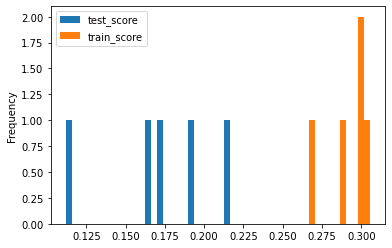

CIS_P,CIS_P_Score


/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: Fut

,test_score,train_score
0,0.213351,0.268876
1,0.111979,0.305572
2,0.191857,0.288644
3,0.164298,0.301566
4,0.172211,0.298639


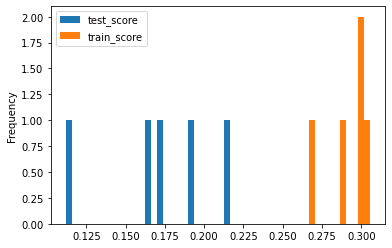

WHODAS_SR,WHODAS_SR_Score


/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: Fut

,test_score,train_score
0,0.213351,0.268876
1,0.111979,0.305572
2,0.191857,0.288644
3,0.164298,0.301566
4,0.172211,0.298639


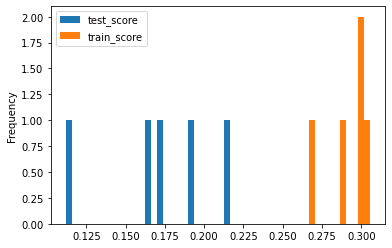

CIS_SR,CIS_SR_Total


/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: Fut

,test_score,train_score
0,0.213351,0.268876
1,0.111979,0.305572
2,0.191857,0.288644
3,0.164298,0.301566
4,0.172211,0.298639


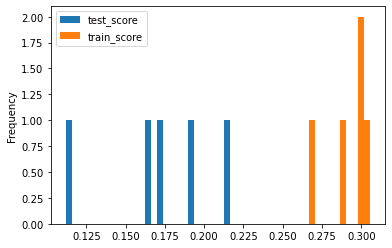

,Output,Mean R2,Std R2,Mean MAE,Std MAE,Target Score Range (for MAE interpretation)
0,"WHODAS_P,WHODAS_P_Total",0.470210,0.050689,7.689281,0.258804,"(0.0, 79.17)"
1,"CIS_P,CIS_P_Score",0.715891,0.034294,3.491327,0.068759,"(0, 49)"
2,"WHODAS_SR,WHODAS_SR_Score",0.067559,0.018531,11.895153,0.580488,"(0.0, 100.0)"
3,"CIS_SR,CIS_SR_Total",0.170739,0.033936,6.175147,0.293086,"(0, 47)"


In [58]:
# Check cross-validation performance of the final model on validation set for all models
def plot_test_vs_train_scores(cv_results):
    scores = pd.DataFrame(cv_results)[["test_score", "train_score"]]
    display(scores)
    scores.plot.hist(bins=50)
    plt.show()

results_val_set = []
for output in output_cols:
    print(output)
    estimator = best_estimators[output]
    r2_cv_results = cross_validate(estimator, train_set[input_cols], train_set[output], return_train_score = True, scoring="r2")
    r2_scores = [np.mean(r2_cv_results["test_score"]), np.std(r2_cv_results["test_score"])]
    mae_cv_results = cross_validate(estimator, train_set[input_cols], train_set[output], return_train_score = True, scoring="neg_mean_absolute_error")
    mae_scores = [np.mean(-mae_cv_results["test_score"]), np.std(-mae_cv_results["test_score"])]
    results_val_set.append([
        output, 
        *r2_scores,
        *mae_scores,
        get_min_max_for_mae_interpretation(output)])
    
    plot_test_vs_train_scores(cv_results)
restults_val_set_df = pd.DataFrame(results_val_set, columns=["Output"] + ["Mean R2", "Std R2", "Mean MAE", "Std MAE", "Target Score Range (for MAE interpretation)"])
display(restults_val_set_df)

In [60]:
display(restults_val_set_df[["Output", "Mean R2", "Mean MAE", "Target Score Range (for MAE interpretation)"]])

,Output,Mean R2,Mean MAE,Target Score Range (for MAE interpretation)
0,"WHODAS_P,WHODAS_P_Total",0.470210,7.689281,"(0.0, 79.17)"
1,"CIS_P,CIS_P_Score",0.715891,3.491327,"(0, 49)"
2,"WHODAS_SR,WHODAS_SR_Score",0.067559,11.895153,"(0.0, 100.0)"
3,"CIS_SR,CIS_SR_Total",0.170739,6.175147,"(0, 47)"


WHODAS_P,WHODAS_P_Total
r2:  0.5402023469800292


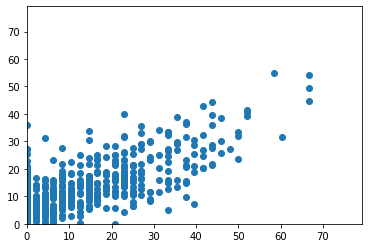

,y,y pred
39,29.17,29.641208
147,29.17,24.272274
270,29.17,11.661123
286,29.17,8.389591
315,29.17,30.053342
411,29.17,11.668551
429,29.17,23.358282
433,29.17,8.991701


CIS_P,CIS_P_Score
r2:  0.7602502630510777


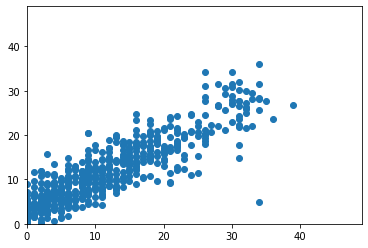

,y,y pred
0,31,27.715612
22,31,21.743435
39,30,30.763782
42,30,27.887864
119,31,26.546374
143,31,23.579096
177,30,34.281387
190,29,30.587972
192,31,27.646134
229,31,30.185860


WHODAS_SR,WHODAS_SR_Score
r2:  0.23210193591389627


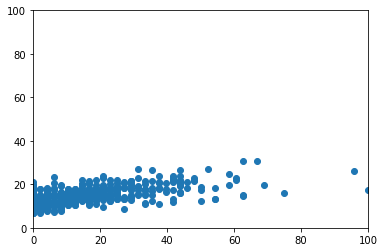

,y,y pred
27,29.17,20.125256
53,29.17,14.380219
135,29.17,21.326567
148,29.17,14.225596
188,29.17,21.379696
194,29.17,18.389400
255,29.17,17.638148
281,29.17,17.257696
298,29.17,19.594564
366,29.17,12.601084


CIS_SR,CIS_SR_Total
r2:  0.24055228217867297


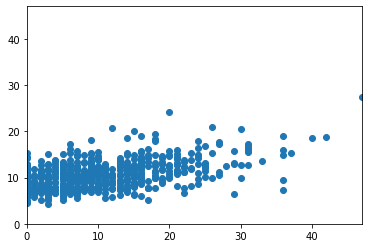

,y,y pred
0,30,20.410671
43,31,16.765582
46,29,12.884196
91,31,16.265902
98,30,9.976014
106,30,12.637787
190,29,15.744651
207,29,6.348041
234,31,12.693486
321,31,17.150626


,Output,r2,MAE,Target Score Range (for MAE interpretation)
1,"CIS_P,CIS_P_Score",0.760250,3.351484,"(0, 49)"
0,"WHODAS_P,WHODAS_P_Total",0.540202,6.871698,"(0.0, 79.17)"
3,"CIS_SR,CIS_SR_Total",0.240552,5.752031,"(0, 47)"
2,"WHODAS_SR,WHODAS_SR_Score",0.232102,9.933410,"(0.0, 100.0)"


In [64]:
# Check performance of the final model on test set for all models

results_test_set = []
for output in output_cols:
    estimator = best_estimators[output]
    metrics = get_metrics(estimator, output, input_cols, 'test', 1)
    results_test_set.append([
        output, 
        *metrics])
restults_test_set_df = pd.DataFrame(results_test_set, columns=["Output"] + metric_names)
restults_test_set_df.sort_values(by="r2", ascending=False)

### Feature importance

In [44]:
if IMPORTANCES_FROM_FILE == 1:
    forward_feature_objects = {}
    backward_feature_objects = {}
    try:
        forward_feature_objects = load('forward-sfs-imp-item-lvl.joblib')
    except Exception as e: print(e)

/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator SimpleImputer from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator ElasticNet from version 1.0.2 when using version 1.1.1. Th

In [45]:
# Find elbow of the curve (draw a line from the first to the last point of the curve and then find the data point that is farthest away from that line) https://stackoverflow.com/questions/2018178/finding-the-best-trade-off-point-on-a-curve 
def find_elbow(curve):
    from numpy import matlib 
    n_points = len(curve)
    all_coord = np.vstack((range(n_points), curve)).T
    first_point = all_coord[0]
    line_vec = all_coord[-1] - all_coord[0]
    line_vec_norm = line_vec / np.sqrt(np.sum(line_vec**2))
    vec_from_first = all_coord - first_point
    scalar_product = np.sum(vec_from_first * np.matlib.repmat(line_vec_norm, n_points, 1), axis=1)
    vec_from_first_parallel = np.outer(scalar_product, line_vec_norm)
    vec_to_line = vec_from_first - vec_from_first_parallel
    dist_to_line = np.sqrt(np.sum(vec_to_line ** 2, axis=1))
    idx_of_best_point = np.argmax(dist_to_line)
    return idx_of_best_point + 1

def analyze_importances(importances):
    importances_list = []
    for key in importances:
        importances_list.append(importances[key]['avg_score'])
    importances_df = pd.DataFrame(importances_list, index=importances.keys(), columns=["r2"])
    display(importances_df)

    max_score = max(importances_list)
    n_cols_max_score = importances_df[importances_df["r2"] == max_score].index[0]
    print("Max score: ", max_score, " at ", n_cols_max_score, " features")
    features_up_to_max_score = importances[n_cols_max_score]["feature_names"]

    plt.figure(figsize=(16,8))
    plt.plot(importances_df)
    plt.xticks(np.arange(1,100, 3))
    plt.vlines(np.arange(1,100, 3), ymin=min(importances_list), ymax=max(importances_list), colors='purple', ls=':', lw=1)
    plt.show()
    
    optimal_nb_features = find_elbow(importances_list)
    print("Optimal number of features: ", optimal_nb_features)
    
    features_up_to_optimal = importances[optimal_nb_features]["feature_names"]
    display(features_up_to_optimal)
    
    return (features_up_to_optimal, features_up_to_max_score)

In [46]:
from mlxtend.feature_selection import SequentialFeatureSelector

if IMPORTANCES_FROM_FILE == 0:
    forward_feature_subsets = {}
    forward_feature_objects = {}
    for output in output_cols:
        print(output)
        estimator = best_estimators[output]

        sfs = SequentialFeatureSelector(estimator, 
              k_features=100,
              forward=True, 
              scoring='r2',
              cv=3,
              n_jobs=-1)

        sfs = sfs.fit(train_set[input_cols], train_set[output])

        forward_feature_subsets[output] = sfs.subsets_
        forward_feature_objects[output] = sfs
        
        analyze_importances(forward_feature_objects[output].subsets_)

In [47]:
# Save importances to file
if IMPORTANCES_FROM_FILE == 0:
    dump(forward_feature_objects, 'forward-sfs-imp-item-lvl.joblib', compress=1)

WHODAS_P,WHODAS_P_Total


,r2
1,0.174862
2,0.272092
3,0.331146
4,0.363643
5,0.387115
...,...
96,0.553514
97,0.553523
98,0.553528
99,0.553531


Max score:  0.5535311165293016  at  100  features


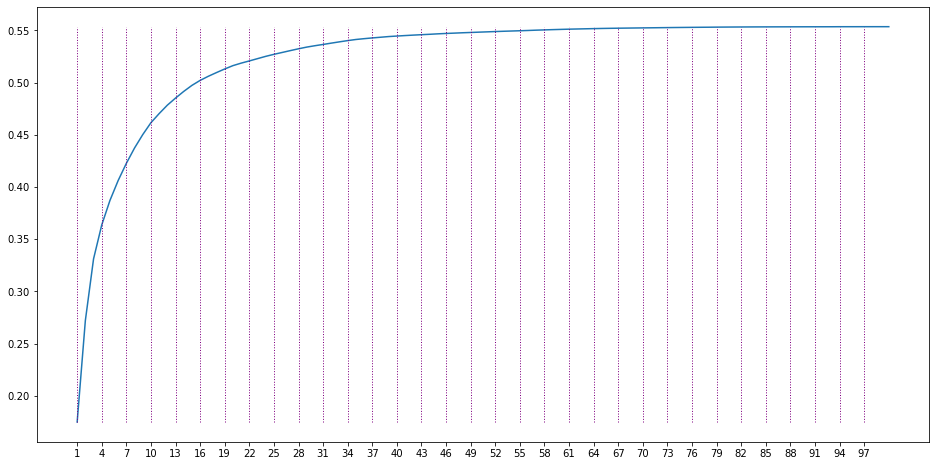

Optimal number of features:  17


('SympChck,CSC_18C',
 'ASSQ,ASSQ_24',
 'SDQ,SDQ_26',
 'SDQ,SDQ_29_b',
 'SRS,SRS_01',
 'SRS,SRS_34',
 'SRS,SRS_37',
 'SRS,SRS_44',
 'SRS,SRS_49',
 'CBCL,CBCL_04',
 'CBCL,CBCL_24',
 'CBCL,CBCL_62',
 'ESWAN,SocAnx_05',
 'MFQ_P,MFQ_P_06',
 'MFQ_P,MFQ_P_21',
 'PSI,PSI_21',
 'RBS,RBS_02')

Score using all features: 
WHODAS_P,WHODAS_P_Total
r2:  0.48151379535572725


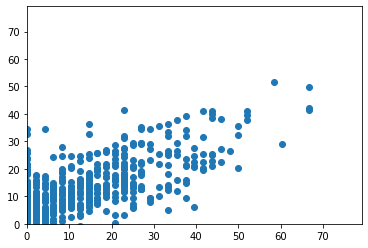

R2:  0.48151379535572725
Performance on test set using optimal number of columns: 
WHODAS_P,WHODAS_P_Total
r2:  0.48445571582502067


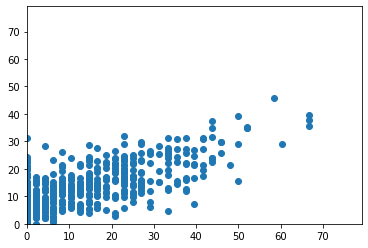

R2:  0.48445571582502067
Performance on test set using number of columns with maximum score
WHODAS_P,WHODAS_P_Total
r2:  0.5008692953823204


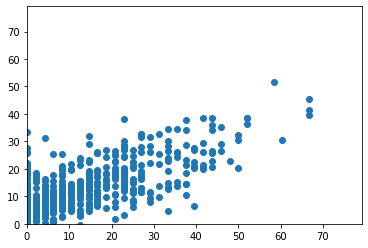

R2:  0.5008692953823204
CIS_P,CIS_P_Score


,r2
1,0.338756
2,0.469494
3,0.533616
4,0.568230
5,0.599893
...,...
96,0.756790
97,0.756813
98,0.756832
99,0.756850


Max score:  0.7568581814480574  at  100  features


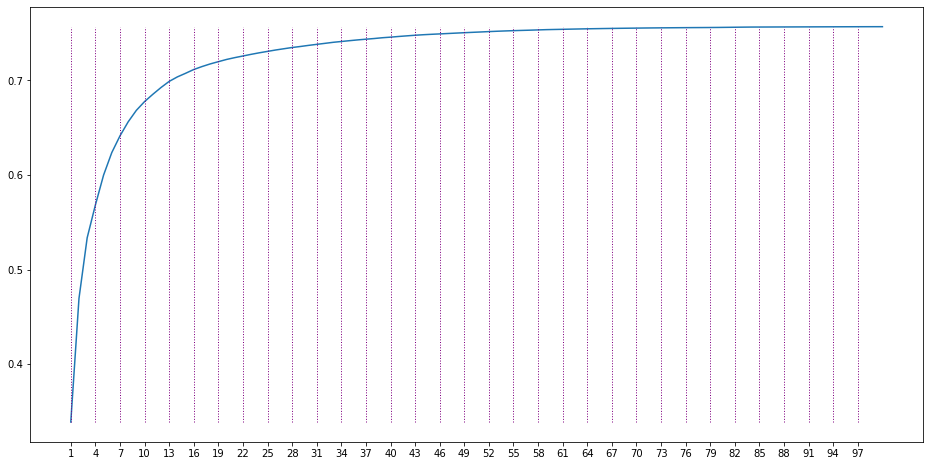

Optimal number of features:  14


('ASSQ,ASSQ_18',
 'ARI_P,ARI_P_01',
 'ARI_P,ARI_P_05',
 'SDQ,SDQ_12',
 'SDQ,SDQ_26',
 'SWAN,SWAN_04',
 'SRS,SRS_64',
 'CBCL,CBCL_103',
 'CBCL,CBCL_23',
 'CBCL,CBCL_50',
 'ICU_P,ICU_P_09',
 'PCIAT,PCIAT_18',
 'ESWAN,DMDD_10A',
 'PSI,PSI_35')

Score using all features: 
CIS_P,CIS_P_Score
r2:  0.7284095439938671


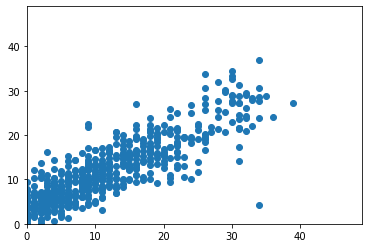

R2:  0.7284095439938671
Performance on test set using optimal number of columns: 
CIS_P,CIS_P_Score
r2:  0.6965497631704788


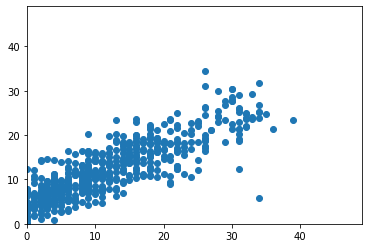

R2:  0.6965497631704788
Performance on test set using number of columns with maximum score
CIS_P,CIS_P_Score
r2:  0.7417813496184045


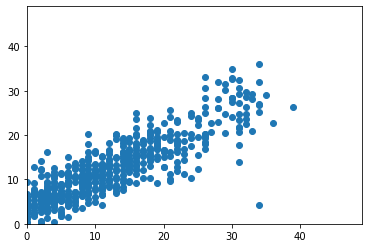

R2:  0.7417813496184045
WHODAS_SR,WHODAS_SR_Score


,r2
1,0.023636
2,0.043493
3,0.052083
4,0.059822
5,0.062507
...,...
96,0.095107
97,0.096638
98,0.096086
99,0.095891


Max score:  0.10332448497746367  at  35  features


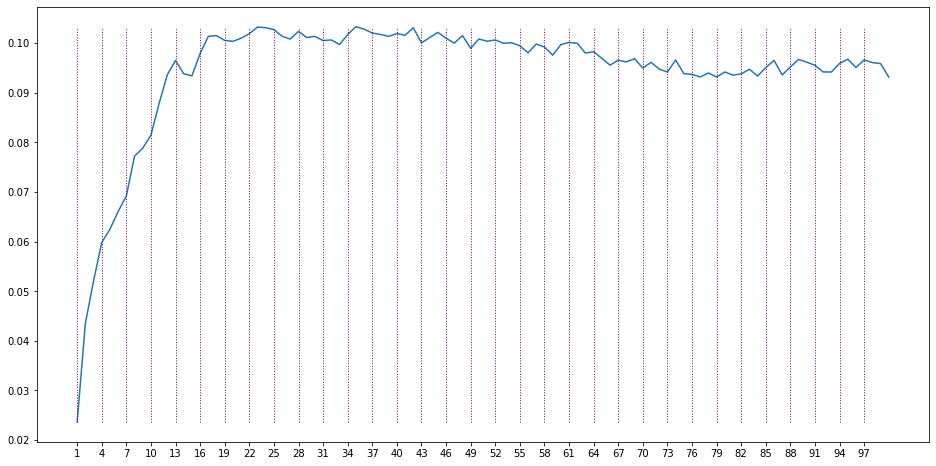

Optimal number of features:  17


('SympChck,CSC_08C',
 'SympChck,CSC_11C',
 'SympChck,CSC_55bC',
 'SDQ,SDQ_07',
 'SDQ,SDQ_23',
 'SRS,SRS_14',
 'SRS,SRS_36',
 'SRS,SRS_49',
 'CBCL,CBCL_12',
 'APQ_P,APQ_P_42',
 'PCIAT,PCIAT_16',
 'APQ_SR,APQ_SR_07A',
 'APQ_SR,APQ_SR_24',
 'APQ_SR,APQ_SR_34',
 'APQ_SR,APQ_SR_35',
 'APQ_SR,APQ_SR_39',
 'RBS,RBS_27')

Score using all features: 
WHODAS_SR,WHODAS_SR_Score
r2:  0.023655425370541883


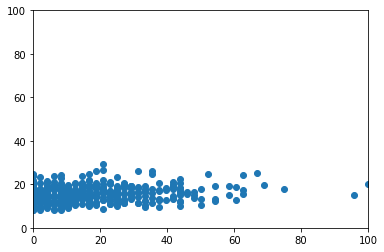

R2:  0.023655425370541883
Performance on test set using optimal number of columns: 
WHODAS_SR,WHODAS_SR_Score
r2:  0.022096320675998316


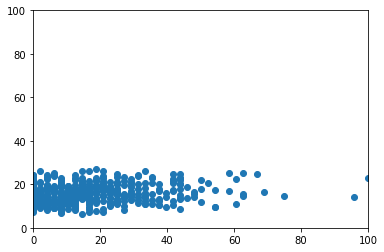

R2:  0.022096320675998316
Performance on test set using number of columns with maximum score
WHODAS_SR,WHODAS_SR_Score
r2:  0.025209170721535723


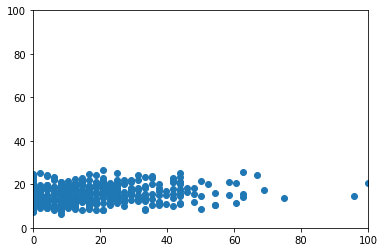

R2:  0.025209170721535723
CIS_SR,CIS_SR_Total


,r2
1,0.072888
2,0.100553
3,0.123440
4,0.139136
5,0.151987
...,...
96,0.207783
97,0.207783
98,0.207783
99,0.207783


Max score:  0.20778308057755132  at  99  features


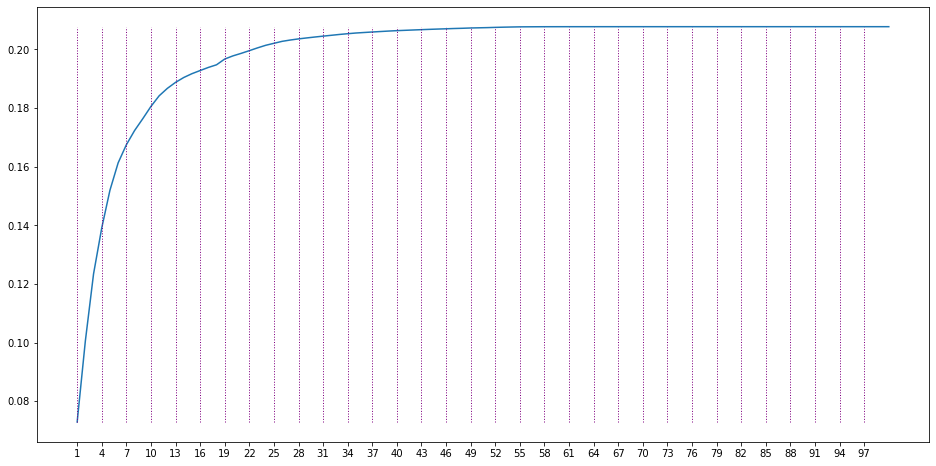

Optimal number of features:  14


('SympChck,CSC_47P',
 'SDQ,SDQ_13',
 'SDQ,SDQ_24',
 'CBCL,CBCL_23',
 'MFQ_P,MFQ_P_15',
 'MFQ_P,MFQ_P_29',
 'APQ_SR,APQ_SR_02',
 'APQ_SR,APQ_SR_07A',
 'APQ_SR,APQ_SR_12',
 'APQ_SR,APQ_SR_31',
 'APQ_SR,APQ_SR_33',
 'APQ_SR,APQ_SR_35',
 'APQ_SR,APQ_SR_37',
 'APQ_SR,APQ_SR_39')

Score using all features: 
CIS_SR,CIS_SR_Total
r2:  0.1958002001573116


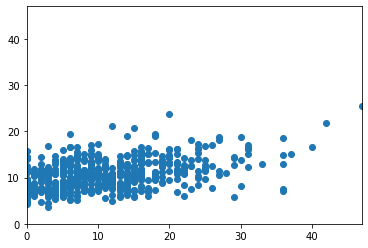

R2:  0.1958002001573116
Performance on test set using optimal number of columns: 
CIS_SR,CIS_SR_Total
r2:  0.1957896692346982


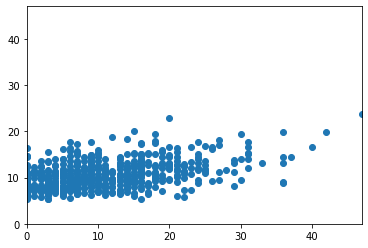

R2:  0.1957896692346982
Performance on test set using number of columns with maximum score
CIS_SR,CIS_SR_Total
r2:  0.20680739503203183


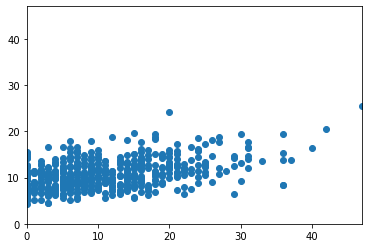

R2:  0.20680739503203183


In [48]:
# Print sfs results
for output in output_cols:
    print(output)
    
    features_up_to_optimal, features_up_to_max_score = analyze_importances(forward_feature_objects[output].subsets_)
    features_up_to_optimal = list(features_up_to_optimal)
    features_up_to_max_score = list(features_up_to_max_score)
    
    # Test both subsets on test set
    estimator = best_estimators[output]
    
    # All features
    # Create new pipeline with the same params (need to re-train the imputer on less features)
    new_estimator = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), StandardScaler(), estimator[2])
    new_estimator.fit(train_set[input_cols], train_set[output])
    print("Score using all features: ")
    metrics = get_metrics(new_estimator, output, input_cols, 'test', 1)
    print("R2: ", metrics[metric_names.index("r2")])
    
    # Create new pipeline with the same params (need to re-train the imputer on less features)
    new_estimator = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), StandardScaler(), estimator[2])
    new_estimator.fit(train_set[features_up_to_optimal], train_set[output])
    print("Performance on test set using optimal number of columns: ")
    metrics = get_metrics(new_estimator, output, features_up_to_optimal, 'test', 1)
    print("R2: ", metrics[metric_names.index("r2")])

    # Create new pipeline with the same params (need to re-train the imputer on less features)
    new_estimator = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), StandardScaler(), estimator[2])
    new_estimator.fit(train_set[features_up_to_max_score], train_set[output])
    print("Performance on test set using number of columns with maximum score")
    metrics = get_metrics(new_estimator, output, features_up_to_max_score, 'test', 1)
    print("R2: ", metrics[metric_names.index("r2")])